In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchvision import models


2024-02-05 18:43:12.457563: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 18:43:12.483436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 18:43:12.483470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 18:43:12.484302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 18:43:12.490623: I tensorflow/core/platform/cpu_feature_guar

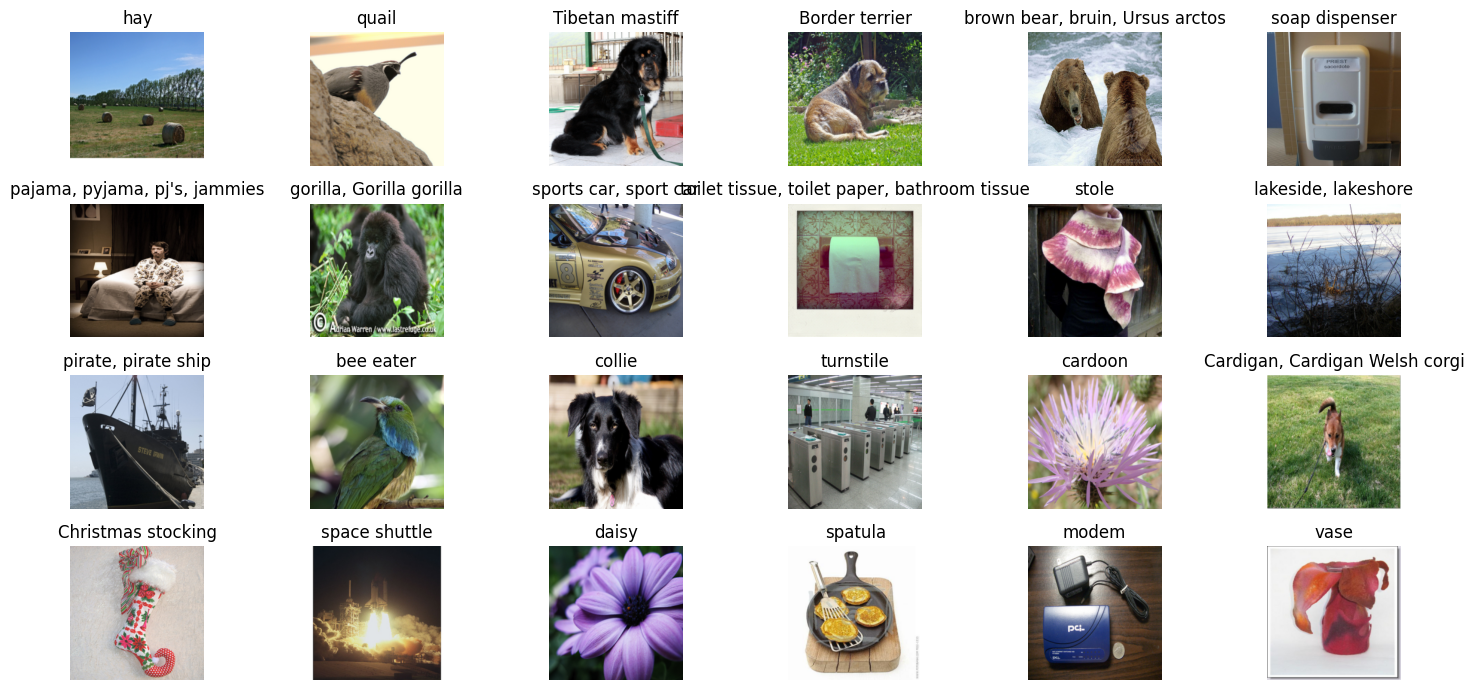

In [52]:
file_name_25_img = 'imagenet_val_25.npz'
if not os.path.exists(file_name_25_img):
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-b/imagenet_val_25.npz

f = np.load("imagenet_val_25.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

y_long = torch.tensor(y, dtype=torch.long)
one_hot_y = F.one_hot(y_long, num_classes=1000)
one_hot_y = one_hot_y.float()

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()


In [53]:
# Load the model
model = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.DEFAULT)

# Model in test mode
model.eval()

# Freeze the weights
for param in model.parameters():
    param.requires_grad = False

In [56]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_squeezenet(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

def deprocess_squeezenet(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else transforms.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = 0, 255
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


In [58]:
X_process = preprocess_squeezenet(rescale(X))

TypeError: Unexpected type <class 'numpy.ndarray'>

In [5]:
# !pip install grad-cam

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

target_layers = [model.layer4[-1]]
input_tensor = torch.cat([preprocess_squeezenet(Image.fromarray(x)) for x in X], dim=0)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

targets = [ClassifierOutputTarget(class_id) for class_id in y]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

print(grayscale_cam.shape)

(25, 224, 224)


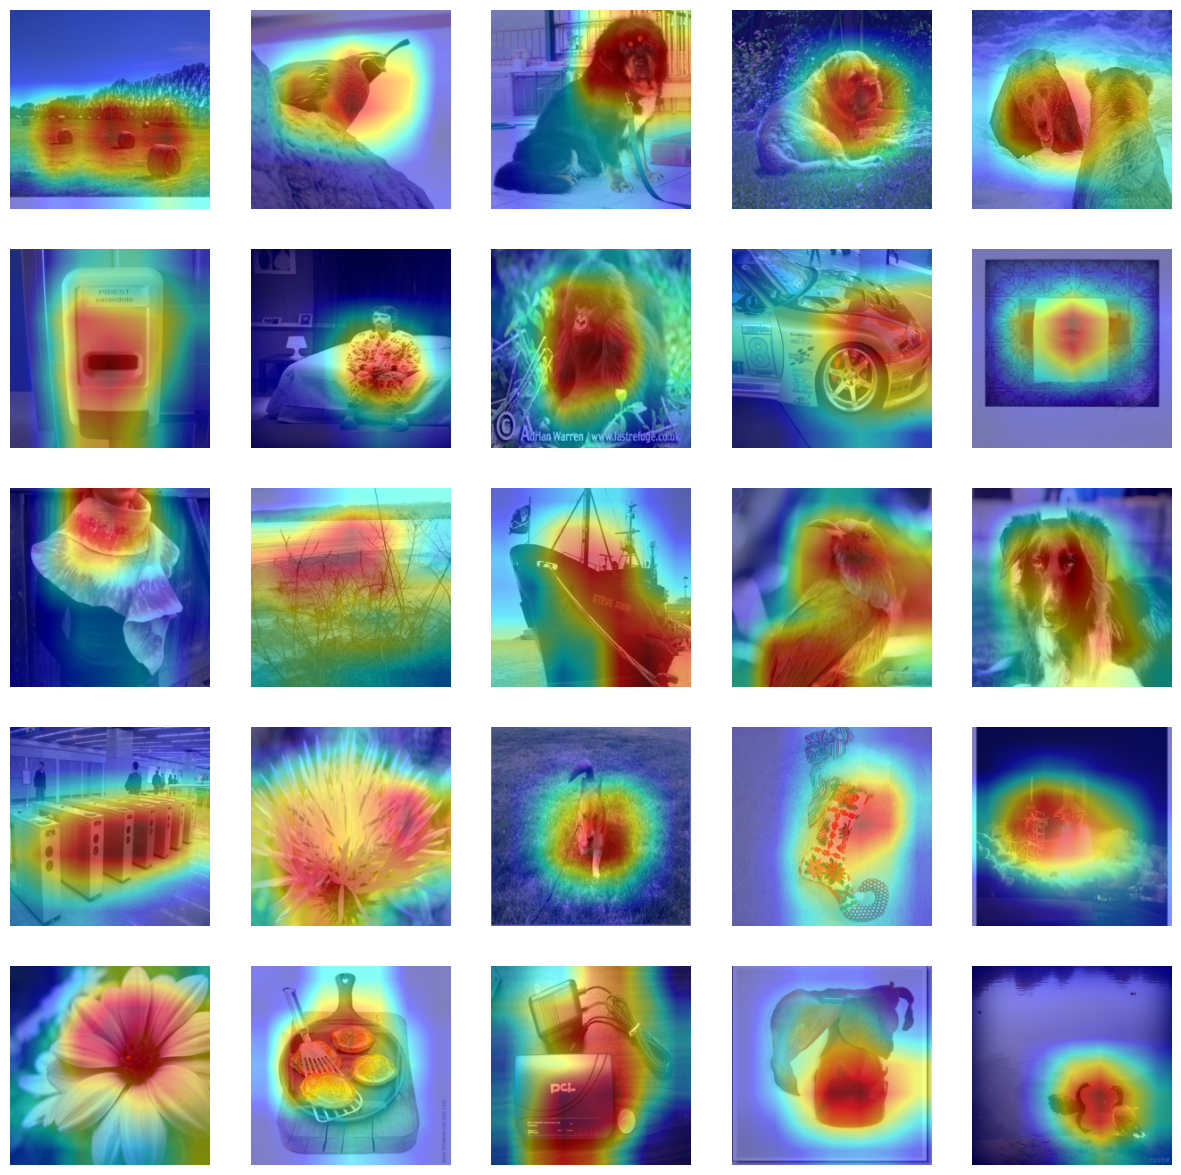

In [6]:
grayscale_cams = [cam.squeeze() for cam in grayscale_cam]  # Removing any extra dimensions

num_images_to_display = 25

columns = 5  # Number of columns in the grid
rows = math.ceil(num_images_to_display / columns)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i in range(num_images_to_display):
    if i < len(X):
        # Normalize image
        img = X[i] / 255.0
        img = np.float32(img)  # Ensure it's float32

        # Get the corresponding CAM
        cam_image = grayscale_cams[i]

        # Overlay CAM on the image
        visualization = show_cam_on_image(img, cam_image, use_rgb=True)

        ax = axes[i]
        ax.imshow(visualization)
        ax.axis('off')
    else:
        break  # Break if there are no more images

# Hide any unused axes if there are fewer images than subplots
for ax in axes[num_images_to_display:]:
    ax.axis('off')

plt.show()

**Implementation avec inception_v4**

In [7]:
# !pip install timm
import timm
model_inception = timm.create_model('inception_v4', pretrained=True)
model_inception.eval()
print("yo")

yo


In [8]:
def preprocess_inception_v4(img, size=299):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

In [9]:
with torch.no_grad():
    out = model(torch.Tensor(X[0]).permute(2,0,1).unsqueeze(0))
probabilities = torch.nn.functional.softmax(out[0], dim=0)
print(probabilities.shape)

torch.Size([1000])


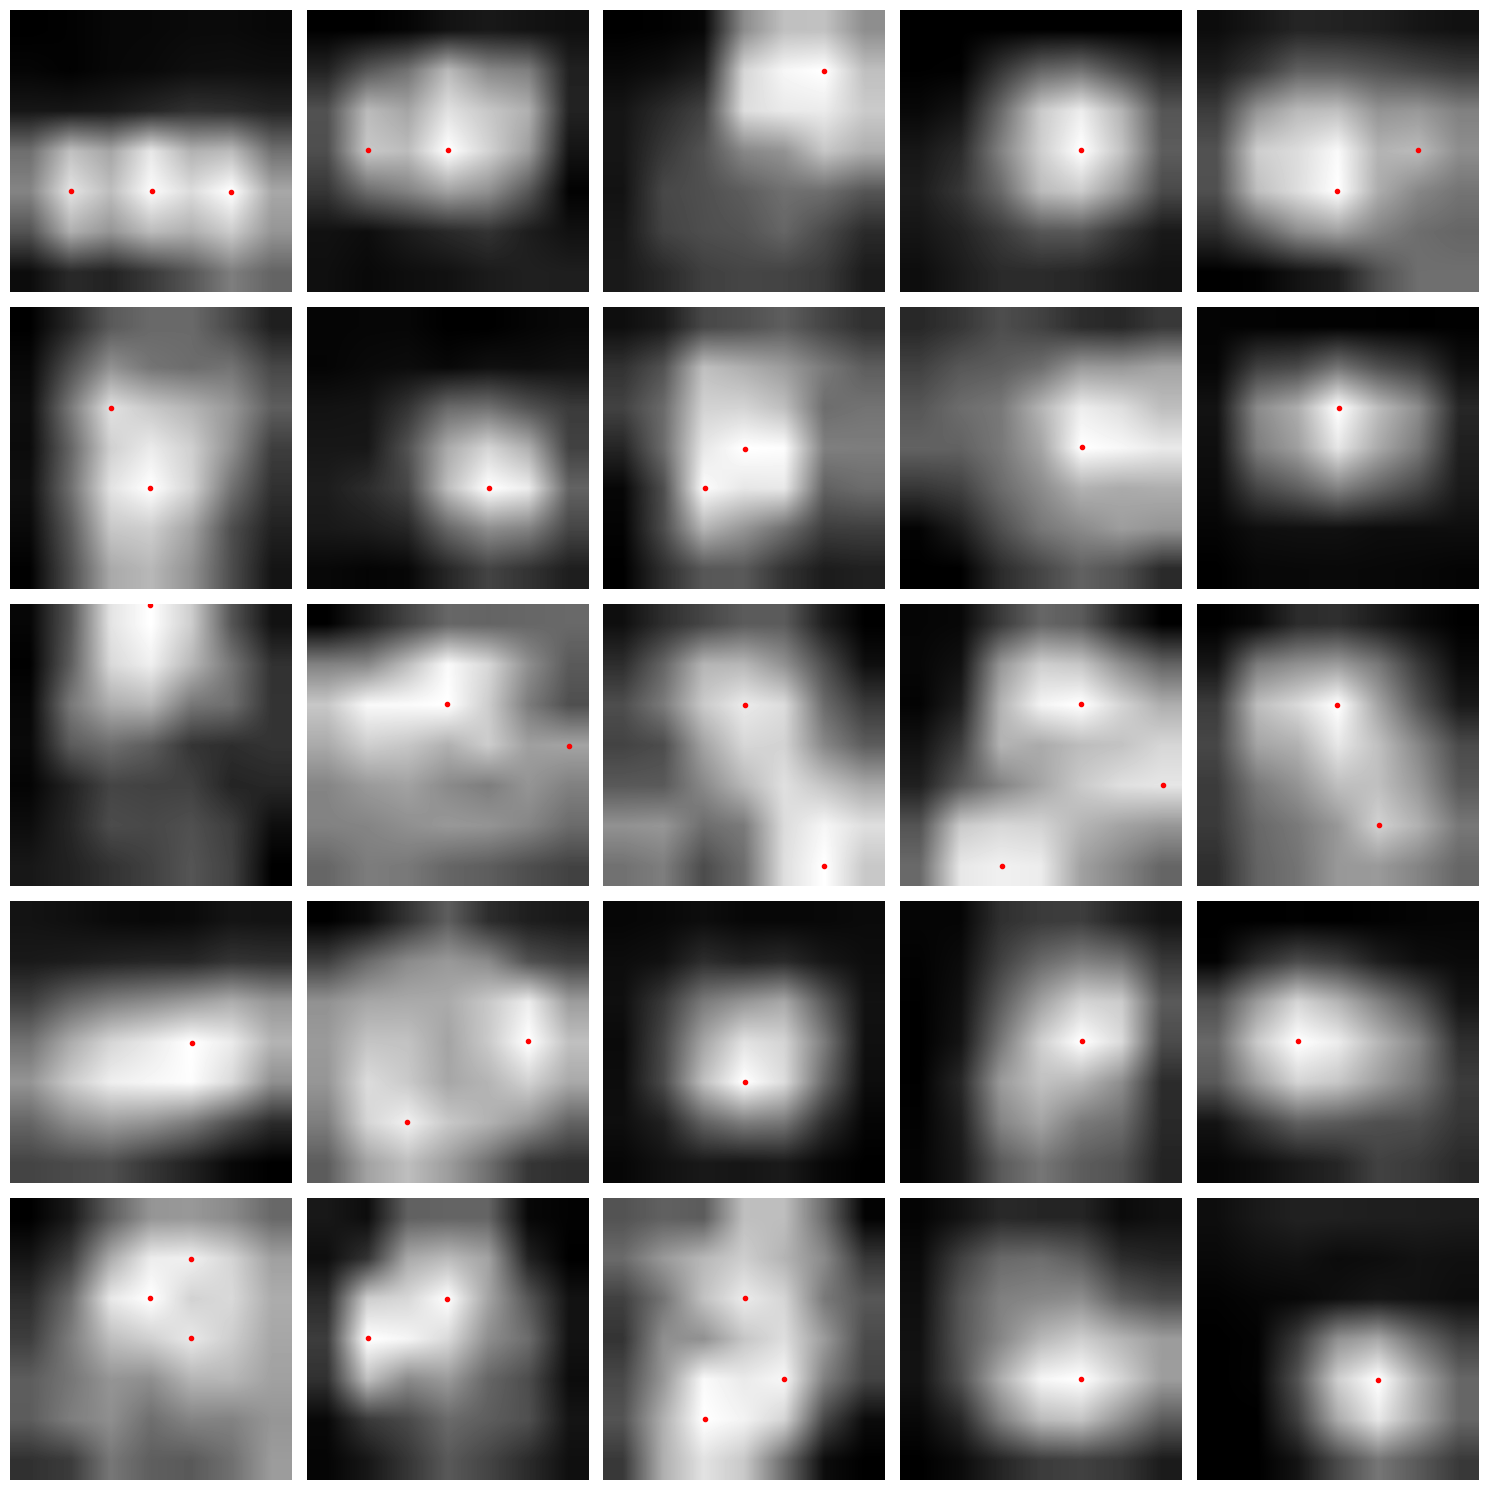

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

# Assuming grayscale_cams is defined
# Example adjustment: Let's create a dummy list of 25 random images for demonstration
# grayscale_cams = [np.random.rand(100, 100) for _ in range(25)]

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    M = grayscale_cams[i]
    ax.imshow(M, cmap='gray')

    # Find coordinates of local maxima
    coordinates = peak_local_max(M, num_peaks=3, exclude_border=False, min_distance=20)

    # Extract the values at these coordinates
    maxima_values = M[coordinates[:, 0], coordinates[:, 1]]

    # Determine the highest value among the maxima
    highest_maxima_value = max(maxima_values)

    # Filter coordinates based on the threshold
    filtered_coordinates = coordinates[maxima_values >= 0.6 * highest_maxima_value]

    # Plot the filtered coordinates on the images
    ax.plot(filtered_coordinates[:, 1], filtered_coordinates[:, 0], 'r.')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [37]:
def get_centers(M, ratio_threshold = 0.6, min_distance = 20):
    # Find coordinates of local maxima
    coordinates = peak_local_max(M, num_peaks=3, exclude_border=False, min_distance=min_distance)

    if len(coordinates) == 0:
        # If no local maxima are found, find the global maximum
        print("No local maxima found. Returning global maximum.")
        global_max_index = np.unravel_index(np.argmax(M), M.shape)
        return np.array([global_max_index])  # Return as a 2D array similar to peak_local_max output

    # Extract the values at these coordinates
    maxima_values = M[coordinates[:, 0], coordinates[:, 1]]

    # Determine the highest value among the maxima
    highest_maxima_value = max(maxima_values)

    # Filter coordinates based on the threshold
    filtered_coordinates = coordinates[maxima_values >= ratio_threshold * highest_maxima_value]
    return filtered_coordinates

In [47]:
def ADP(x_clean, y_true, model, ratio_threshold, min_distance, eps, T, alpha, beta, m):
  #y_true = np.argmax(torch.nn.functional.softmax(model(x_clean)[0], dim=0))

  target_layers = [model.layer4[-1]]
  cam = GradCAM(model=model, target_layers=target_layers)

  targets = [ClassifierOutputTarget(np.argmax(y_true))]

  x_adv = torch.clone(x_clean).detach()

  W, H = x_clean.shape[1], x_clean.shape[2]

  criterion = torch.nn.CrossEntropyLoss()

  for t in range(0, T):
    print(f"iteration {t}")
    g=0
    M = cam(input_tensor=x_adv, targets=targets)

    centers = get_centers(M[0], ratio_threshold, min_distance)

    for center in centers:

      for k in range(1, m+1):
        x1 = int(max(center[0]-beta*k, 0))
        x2 = int(min(center[0]+beta*k, W))
        y1 = int(max(center[1]-beta*k, 0))
        y2 = int(min(center[1]+beta*k, H))

        x_drop = torch.clone(x_adv).detach()
        x_drop[:, x1:x2, y1:y2] = x_clean[:, x1:x2, y1:y2]
        x_drop = x_drop.detach()
        x_drop.requires_grad_(True)


        loss = criterion(model(x_drop)[0], y_true)
        loss.backward()

        grad = x_drop.grad.data
        g += grad

    g *= 1/(len(centers)*m)


    x_adv_max = x_adv + eps
    x_adv_min = x_adv - eps
    x_adv_max.clamp_(0,1)
    x_adv_min.clamp_(0,1)

    with torch.no_grad():
      g_sign = g.sign()
      perturbed_x_adv = x_adv + alpha * g_sign
      x_adv.data = torch.max(torch.min(perturbed_x_adv.data, x_adv_max), x_adv_min)

  return x_adv

In [48]:
x_clean = torch.Tensor(X[0]).permute(2,0,1).unsqueeze(0)
y_true = one_hot_y[0]
M = cam(input_tensor=x_clean, targets=targets)
M[0].shape
get_centers(M[0], 0.6, 20)

array([[ 47, 143],
       [ 47,  79],
       [208,  48]])

In [49]:
x_adv = ADP(x_clean, y_true, model, 0.6, 20, eps=16/255, T=20, alpha=1.6, beta=15, m=5)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
No local maxima found. Returning global maximum.
iteration 6
iteration 7
No local maxima found. Returning global maximum.
iteration 8
No local maxima found. Returning global maximum.
iteration 9
iteration 10
No local maxima found. Returning global maximum.
iteration 11
iteration 12
No local maxima found. Returning global maximum.
iteration 13
iteration 14
No local maxima found. Returning global maximum.
iteration 15
No local maxima found. Returning global maximum.
iteration 16
No local maxima found. Returning global maximum.
iteration 17
No local maxima found. Returning global maximum.
iteration 18
iteration 19
No local maxima found. Returning global maximum.


torch.Size([1, 3, 224, 224])


TypeError: Invalid shape (3, 224, 224) for image data

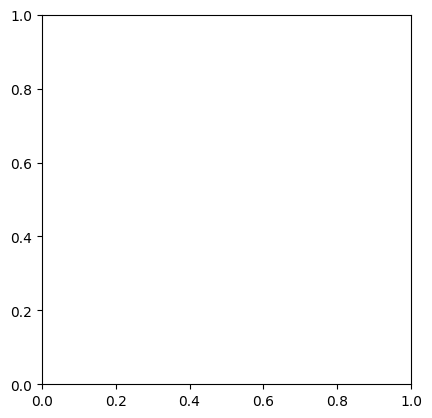

In [50]:
print(x_adv.shape)
plt.imshow(x_adv[0])